# CSE 152A Winter 2024 – Assignment 3

Assignment Published On: **Thu, Feb 15, 2024**

Due On: **Mon, Feb 26, 2024 11:59 PM (Pacific Time)**

Instructions:
- Attempt all questions.
- Please comment all your code adequately.
- **Please install following packages in order to run the code: OpenCV, matplotlib, scikit-learn**
- Please write your code at the ``WRITE YOUR CODE HERE'' prompt in the .ipynb file. 

## Problem 1: Image Classiﬁcation Using Bag-of-words [20 pts]

We will now build a classifier to determine whether an input image contains a cat or a dog. A training dataset has been provided consisting of cat and dog images, you are first highly encouraged to look at the images manually to get a feel for the problem. We will create a bag-of-words representation for images and use K-nearest neighbor classification. 

**Note**: For this problem, it is not important to get high accuracies, but just be able to see how an example of an entire pipeline for image classification works.

## Review of bag-of-words for image classification

We will solve image classification, with the relatively simple but effective bag-of-words approach. We treat an image as a set of regions and ignore the spatial relationships between different regions. The image classification problem can then be solved by counting the frequencies of different regions appearing in an image. Image classification using bag-of-words includes the following steps: 

* **Region Selection**: Select some regions in the images so that we can extract features from those regions in the next step. The regions can be selected by feature detection methods like edge or corner detection, or you can just uniformly sample the image. 

* **Feature Extraction**: We extract features from the selected regions. One commonly used feature is SIFT. We extract features from every image in the training set. These features are collected to compute the visual vocabulary for image representation.  

* **Building visual vocabulary**: Once we have the features extracted from training images, we build a visual vocabulary by grouping them together to form a few clusters. We will use the k-means algorithm to group the features. The reason why we need this step is to reduce the redundancy in feature space and have a more concise feature representation of images. 

* **Learning and recognition**: Given the visual vocabulary, each training image is represented by a histogram, where the features in the image populate bins that correspond to the visual word closest to them. Thereafter, we will use k-nearest neighbors to perform classification for a test image, also represented by a histogram using the same vocabulary.

## Simple image classifier
We will make a classifier to tell whether a given image is a cat or a dog. The dataset contains 400 images of cats and 400 images of dogs. We will pick 300 images from each group for training and the other 100 images for testing. The skeleton code is given.

In [1]:
import glob
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Parameters
posData = 'animals/cats/'
negData = 'animals/dogs/'
TrainRatio = 0.75
imSize = 133, 200 # resize each image to this size
nIntPts = 200 # maximum number of interest points to be extracted from an image
wGrid = 5 # width of the small grids for uniform sampling
patchSize = 11 # an odd number indicate patch size for image patch feature
nCluster = 50 # number of cluster in k-means algorithm
random.seed(1234)

def listImage(dataRoot):
    fileList = glob.glob(str(dataRoot + '*.jpg'))
    imNum = len(fileList)
    fileList = [fileList[i].replace('\\', '/') for i in range(imNum)]
    return fileList

def loadImage(imgName, imSize):
    # load image, resize and make RGB to grayscale
    img = cv2.imread(imgName)
    img = cv2.resize(img, (imSize[1], imSize[0]))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def createSplit(imgList, ratio):
    random.shuffle(imgList)
    trainList = imgList[:round(len(imgList)*ratio)]
    testList = imgList[round(len(imgList)*ratio):]
    return trainList, testList

# Data preprocessing: Create Training / Testing Split
posList = listImage(posData)
negList = listImage(negData)
trainPosList, testPosList = createSplit(posList, TrainRatio)
trainNegList, testNegList = createSplit(negList, TrainRatio)
trainList = trainPosList + trainNegList
trainLabel = np.concatenate((np.ones(len(trainPosList)), np.zeros(len(trainNegList))))
testList = testPosList + testNegList
testLabel = np.concatenate((np.ones(len(testPosList)), np.zeros(len(testNegList))))
testPosLabel = np.ones(len(testPosList))
testNegLabel = np.zeros(len(testNegList))

## 1.1 Extract interest points from images [2 pts]

You will now try two methods for this: 

* **(a) Uniformly sample the images.** You can divide the image into regular grids and choose a point in each grid and then uniformly choose `nPts` number of interest points. 
* **(b) Sample on corners.** First use the Harris Corner detector to detect corners in the image and then uniformly choose `nPts` number of interest points. (This has already been implemented for you as an example.) 

In [ ]:
def uniformSampling(imSize, nPts, wGrid):
    ''' Uniformly sample the images.
    Args: 
        imSize: size of images (height, width)
        nPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
    Return:
        pts: a list of interest points (Yi, Xi)
    '''
    pts = []
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return pts

def cornerSampling(img, nPts):
    '''
    Args: 
        img: image which you want to extract interest points
        nPts: maximum number of interest points to be extracted
    Return:
        pts: a list of interest points (Yi, Xi)
    '''
    dst = cv2.cornerHarris(img,2,3,0.04)
    dst = cv2.dilate(dst,None)
    cor = np.zeros(img.shape)
    cor[dst>0.01*dst.max()]=[1]
    ptsY, ptsX = np.where(cor==1)
    num = min(nPts, len(ptsY))
    choice = np.random.choice(len(ptsY), num, replace=False)
    ptsY = ptsY[choice]
    ptsX = ptsX[choice]
    pts = [(ptsY[i], ptsX[i]) for i in range(num)]
    return pts

def plotInterestPoints(img, pts, idx=0):
    ptsMap = np.zeros(img.shape)
    ptsY = [Y for Y, X in pts]
    ptsX = [X for Y, X in pts]
    ptsMap[ptsY, ptsX] = 1
    plt.figure(idx)
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(ptsMap,cmap = 'gray')
    plt.title('Interest Points Image'), plt.xticks([]), plt.yticks([])

# Here is the code for you to test your implementation
sampleImg = loadImage(trainList[0], imSize)
print('Interest Points extracted by uniform (above) and edge (below) method:')
ptsU = uniformSampling(imSize, nIntPts, wGrid)
plotInterestPoints(sampleImg, ptsU, idx=0)
ptsE = cornerSampling(sampleImg, nIntPts)
plotInterestPoints(sampleImg, ptsE, idx=1)

## 1.2. Extract features [2 pts]
You are required to try two kinds of features: 
* **(a) SIFT feature.** Here we use the SIFT implementation in *OpenCV* package (this has already been implemented for you as an example). 
* **(b) Image Patch feature.** Extract a small image patch around each feature point. You can decide the size of each patch and how many pixels it should cover on you own. 


In [ ]:
def extractSIFTfeature(img, pts):
    '''
    Args:
        img: input image
        pts: detected interest points in the previous step
    Return:
        features: a list of SIFT descriptor features for each interest point
    '''
    sift = cv2.SIFT_create()
    kp = [cv2.KeyPoint(float(ptsX), float(ptsY), 1) for ptsY, ptsX in pts]
    _, des = sift.compute(img, kp)
    features = [des[i] for i in range(des.shape[0])]
    return features

def extractImagePatchfeature(img, pts, patchSize):
    '''
    Args:
        img: input image
        pts: detected interest points in the previous step
        patchSize: an odd number indicate patch size
    Return:
        features: a list of image patch features (1-d) for each interest point
    '''
    features = []
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return features
    
# Here is the code for you to test your implementation
featSIFT = extractSIFTfeature(sampleImg, ptsE)
print('length of SIFT feature list', len(featSIFT))
print('dimension of feature', featSIFT[0].shape) 
featPatch = extractImagePatchfeature(sampleImg, ptsE, patchSize) 
print('length of Image Patch feature list', len(featPatch)) 
print('dimension of feature', featPatch[0].shape) 

## 1.3. Build visual vocabulary [4 pts]
Use k-means clustering to form a visual vocabulary. You can use the python k-means package. You can decide the number of clusters yourself. The default number of cluster centers in k-means is 50. 


### HINT

**getImgFeat** gives you a list of 1-D features of an image. i.e it return a 2-D array of n x m where n is the number of interest points and m is the size of the feature of vector each interest point

**collectFeat** should collect such features for all images in your dataset and return them as a single 2-D array of features. Remember for each image you are generating n features.


**formVisualVocab**
You will have to cluster the features in to K cluster centers. Each center will be represented in the same dimensional space as that of the the feature vector. You will do this iteratively by:   
- first compare each feature vector with the K - cluster centers and assign it the cluster closest to it
- next you will update the cluster center by averaging all the points that were assigned to it
- repeat this process till you see no change in the K centers

Refer: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [ ]:
from sklearn.cluster import KMeans

def getImgFeat(img, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    ''' Output a list of detected features for an image
    Args: 
        img: image which you want to extract interest points
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        extractFeatList: a list of image patch features (1-d) for each interest point
    '''
    if ptType == 'uniform':
        intPts = uniformSampling(imSize, nIntPts, wGrid)
    elif ptType == 'corner':
        intPts = cornerSampling(img, nIntPts)
    else:
        assert False, 'ptType must be either uniform or corner'
        
    if featType == 'sift':
        extractFeatList = extractSIFTfeature(img, intPts)
    elif featType == 'patch':
        extractFeatList = extractImagePatchfeature(img, intPts, patchSize)
    else:
        assert False, 'featType must be either sift or patch'
        
    return extractFeatList

def collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    ''' Collect extracted features for each image among training data
    Args:
        trainList: list of images filepath
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicating the patch size
        ptType: 'uniform' or 'corner' indicates the sampling method used to pick points
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        feats: (# of features, dim of feature) array

    '''
    feats = []
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return feats

def formVisualVocab(feats, nCluster):
    ''' Use k-means algorithm to find k cluster centers, output k-means model
    Args: 
        feats: list of features collected from training data
        nCluster: number of cluster in k-means algorithm
    Return:
        model: k-means model for following steps
    '''
    model = None
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return model

# Here is the code for you to test your implementation
feats = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(feats.shape) # should be (total number of extracted features, dim of feature)
model = formVisualVocab(feats, nCluster)
centers = model.cluster_centers_
print(centers.shape) # should be (nCluster, dim of feature)

## 1.4. Compute histogram representation [4 pts]
Compute the histogram representation of each image, with bins defined over the visual words in the vocabulary. These histograms are the bag-of-words representations of images that will be used for image classiﬁcation. 


#### HINT
In `getHistogram` function you are asked to represent an input image as a histogram over the clusters they are assigned to. Your output should be a 1-D array of the counts of each cluster present in that image,   
In `computeHistograms` You are asked to simply collect and put together the histogram representations of all the images in your training dataset

In [ ]:
def getHistogram(img, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    '''
    Calculate histogram representation for single image
    Args:
        img: input image
        model: k-means model from previous step
        nCluster: number of cluster in k-means algorithm
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        hist: array of shape (nCluster). Histogram representation (1-d) for input image.
    '''
    hist = np.zeros(nCluster)
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return hist
    
def computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    ''' Compute histogram representation for whole training dataset
    Args: 
        trainList: list of images filepath
        model: k-means model from formVisualVocab
        nCluster: number of cluster in k-means algorithm
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        hists: (# of images, nCluster) array - histogram representations among training dataset
    '''
    hists = np.zeros(len(trainList), nCluster)
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return hists
    
# Here is the code for you to test your implementation
hist = getHistogram(sampleImg, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(hist.shape) # should be (nCluster)
hists = computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(hists.shape) # should be (# of training images, nCluster)

## 1.5. K nearest neighbor classifier [4 pts]
After building the visual vocabulary, we now do image classiﬁcation using the nearest neighbors method. Given a new image, first represent it using the visual vocabulary and then find the closest representation in the training set. The test image is assigned the same category as its nearest neighbor in the training set. Next, to make the algorithm more robust, find the first K-nearest neighbors (for K = 3 and 5). 

Refer: 
1. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def KNNclassifier(trainX, trainY, n_neighbors):
    ''' Return a KNN model by fitting training data (trainX, trainY)
    Args:
        trainX: a (# of images, nCluster) array of BoW features for training data
        trainY: a (# of images) array of class label for training data
        n_neighbors: # of neighbors used in KNN classifier
    Return:
        model: KNN classifier model
    '''
    model = None
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return model

def getAccuracy(testX, testY, model):
    ''' Output the testing accuracy for KNN classifier model 
    Args:
        testX: a (# of images, nCluster) array of BoW features for testing data
        testY: a (# of images) array of class label for testing data
        model: KNN classifier model
    Return:
        accu: accuracy of classification prediction on testing data
    '''
    accu = 0.
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    return accu

# Here is the code for you to test your implementation
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
model = KNNclassifier(X, y, n_neighbors=3)
print(model.predict([[1.1]])) # Should be [0]
Xp = [[0.5], [2.5]]
Yp = [0, 0]
acc = getAccuracy(Xp, Yp, model)
print(acc) # Should be 0.5

## 1.6. Calculate testing accuracy [4 pts]
Now we will combine all the modules developed in the previous questions. Use `50 clusters` in k-means and keep other hyperparameters as default, try `K=3` and `K=5` for KNN classifier respectively, report the accuracy in the following two 2D tables. You should report the accuracy of each method on both positive and negative testing samples. Some of the methods may have poor accuracy. But that is fine, don't worry too much about accuracy. You will get full credit as long as you can correctly implement and reason about the various methods. 

                              K=3
|             |  Uniform   | Uniform |  Corners  | Corners |
|:------------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Positive | Negative |
| SIFT Feature |         |         |         |         |
|  Image Patch |         |         |         |         |

                              K=5

|             |  Uniform   | Uniform |  Corners  | Corners |
|:------------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Positive | Negative |
| SIFT Feature |         |         |         |         |
|  Image Patch |         |         |         |         |

## Problem 2:  Bayesian Estimation [20 pts]
**Note**: You can just use pen and paper to do the computations for this problem. It is also fine to use Python or any other means to do the computations.

We wish to classify machine parts of a manufacturer into healthy and damaged. Typically, older machines tend to be more damaged. Our training data consists of 400 parts labeled as healthy and 200 parts as damaged, with the distribution shown in Table 1.

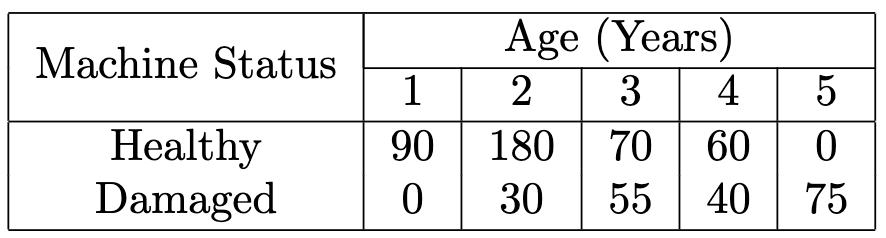
Table 1: Distribution of damaged and healthy machines.      

**2.1** Consider histogram representations for the likelihoods $P(area|healthy)$ and $P(area|damaged)$. Each histogram has 5 bins, of width $1$ unit each and centered at $1, 2, \cdots, 5$. Draw an approximate sketch of the histograms in two separate figures. **[3 points]**

`Ans`:

**2.2** State the procedure to do maximum likelihood (ML) estimation. Use it to determine $damaged$ or $healthy$ labels for three parts, with age 5, 2 and 3 years. **[5 points]**

`Ans`:

**2.3** What is a good prior in this example for $P(damaged)$ and $P(healthy)$? **[2 points]**

`Ans`:

**2.4** Compute and draw approximate curves to illustrate the posterior distributions $P(damaged|area)$ and $P(healthy|area)$. **[5 points]**

`Ans`:

**2.5** State the procedure to do maximum a posteriori (MAP) estimation. Use it to determine $damaged$ or $healthy$ labels for three parts, with age 5, 2 and 3 years.  **[5 points]**

`Ans`: